In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Model
import cv2
import pandas as pd
from tensorflow.keras.models import load_model
import os
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
model = load_model('best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [3]:
dataset_path = "D:/Buku_Tugas_Akhir/Training/traindivide/data_crop/"
def load_and_preprocess_images(data_dir):
    images = []
    labels = []
    label_map = {}
    for label_idx, label_name in enumerate(os.listdir(data_dir)):
        label_map[label_idx] = label_name
        label_path = os.path.join(data_dir, label_name)
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (50, 50))
            images.append(image)
            labels.append(label_idx)
    return np.array(images), np.array(labels), label_map
# Fungsi augmentasi gambar
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])

    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    return imgs
images, labels, label_map = load_and_preprocess_images(dataset_path)
images = np.expand_dims(images, axis=-1)
augmented_images = []
augmented_labels = []
for img, label in zip(images, labels):
    aug_images = img_augmentation(img.squeeze())
    aug_images = np.expand_dims(aug_images, axis=-1)
    augmented_images.extend(aug_images)
    augmented_labels.extend([label] * len(aug_images))

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
final_images = np.concatenate([images, augmented_images])
final_labels = np.concatenate([labels, augmented_labels])

# Konversi label menjadi one-hot encoding
final_labels = to_categorical(final_labels, num_classes=len(label_map))
# Membagi data menjadi training (70%) dan temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(final_images, final_labels, test_size=0.3, stratify=np.argmax(final_labels, axis=1), random_state=42)

# Membagi temporary set menjadi validation dan testing (50% dari temporary set masing-masing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)
# Tampilkan jumlah sampel di setiap set
train_counts = {label: sum(1 for lbl in np.argmax(y_train, axis=1) if lbl == label) for label in range(len(label_map))}
val_counts = {label: sum(1 for lbl in np.argmax(y_val, axis=1) if lbl == label) for label in range(len(label_map))}
test_counts = {label: sum(1 for lbl in np.argmax(y_test, axis=1) if lbl == label) for label in range(len(label_map))}

print("\nJumlah sampel di setiap set:")
print("Training set:")
for label, count in train_counts.items():
    print(f"{label_map[label]}: {count}")
print("\nValidation set:")
for label, count in val_counts.items():
    print(f"{label_map[label]}: {count}")
print("\nTesting set:")
for label, count in test_counts.items():
    print(f"{label_map[label]}: {count}")


Jumlah sampel di setiap set:
Training set:
Agung_Handayanto: 5880
Andi_Agung: 5880
Daniel_Rodearman: 5880
David_Nababan: 5880
Insan_Kamil: 5880
Jona_Meivan: 5880

Validation set:
Agung_Handayanto: 1260
Andi_Agung: 1260
Daniel_Rodearman: 1260
David_Nababan: 1260
Insan_Kamil: 1260
Jona_Meivan: 1260

Testing set:
Agung_Handayanto: 1260
Andi_Agung: 1260
Daniel_Rodearman: 1260
David_Nababan: 1260
Insan_Kamil: 1260
Jona_Meivan: 1260


237/237 [==============================] - 1s 2ms/step


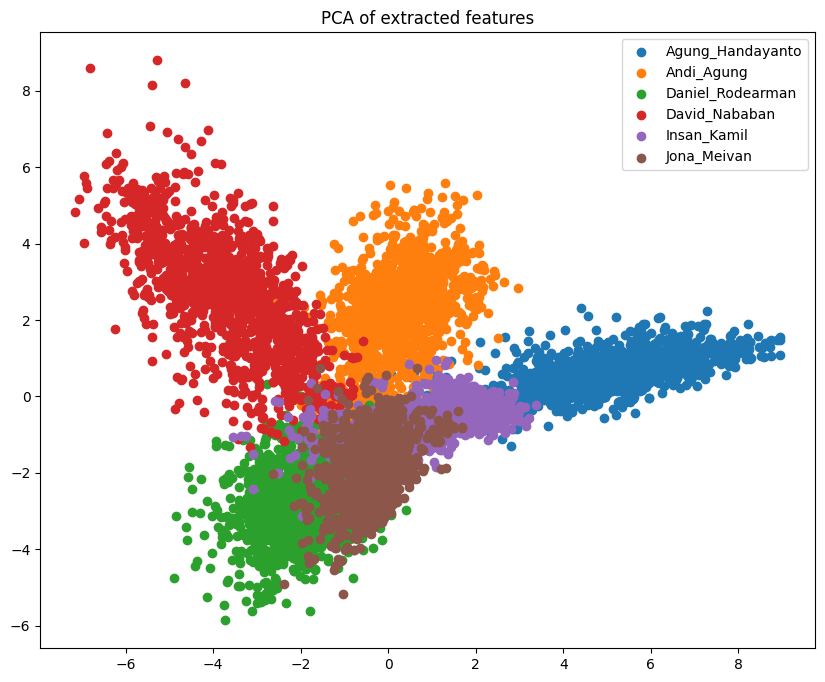

In [9]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
# Membuat model untuk ekstraksi fitur
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense').output)

# Ekstraksi fitur dari data validation
features = feature_extractor.predict(X_val)

# Visualisasi fitur dengan PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in range(len(label_map)):
    indices = np.where(np.argmax(y_val, axis=1) == label)
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=label_map[label])
plt.legend()
plt.title('PCA of extracted features')
plt.show()